# Assignment 3 - Interpolation

## Overview

Interpolate the given data in form of natural cubic spline

- Method: Spline construction under constraints (general interpolation, continuity, smoothness, curvature, etc.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

---

## Question 2

Given the following data

In [3]:
X = np.arange(6)
Y = np.array([12, 14, 22, 39, 58, 77])
data = pd.DataFrame({'X': X,
                     'Y': Y})
data

,X,Y
0,0,12
1,1,14
2,2,22
3,3,39
4,4,58
5,5,77


In [5]:
def coef_matrix(X, Y, print_func = True):
    """  
    This function solves for the coefficients of piecewise natural cubic splines by Gaussian elimination method
    
    Arguments:
    - X [numpy array] consisting of the basis points
    - Y [numpy array] consisting of points as a function of coressponding X
    - print_func [bool] whether to print the whole piece-wise cubic function
    
    Return:
    - coef [numpy array] a matrix of coefficients of piece-wise cubic polynomials 
    """
    
    #(I) Construct M
    #Reshape X, Y
    X = X.reshape(-1,)
    Y = Y.reshape(-1,)
    
    #Number of polynomials - n
    n = len(X) - 1
    
    M = np.array([])
    
    #By general interpolation requirement
    for i in range(n):
        zeros_head = np.zeros((4*i,))
        mi = 1
        zeros_tail = np.zeros((4*(n-i) - 1))
        Mi = np.hstack([zeros_head,
                        mi,
                        zeros_tail])
        M = np.append(M, Mi).reshape(-1, 4*n)
    
    
    dXn = X[-1] - X[-2]
    Mn = np.hstack([np.zeros((4*(n-1))),
                    1, dXn, dXn**2, dXn**3])
    M = np.append(M, Mn).reshape(-1, 4*n)
    
    #By continuity requirement
    for i in range(1, n):
        dXi = X[i] - X[i-1]
        zeros_head = np.zeros((4*(i-1)))
        mi = np.array([1, dXi, dXi**2, dXi**3, -1, 0, 0, 0])
        zeros_tail = np.zeros((4*n - 4*(i-1) - 4*2))
        Mi = np.hstack([zeros_head,
                        mi,
                        zeros_tail])
        M = np.append(M, Mi).reshape(-1, 4*n)
    
    #By smoothness requirement
    for i in range(1,n):
        dXi = X[i] - X[i-1]
        zeros_head = np.zeros((4*(i-1)))
        mi = np.array([0, 1, 2*dXi, 3*dXi**2, 0, -1, 0, 0])
        zeros_tail = np.zeros((4*n - 4*(i-1) - 4*2))
        Mi = np.hstack([zeros_head,
                        mi,
                        zeros_tail])
        M = np.append(M, Mi).reshape(-1, 4*n)
    
    #By curvature requirement
    for i in range(1,n):
        dXi = X[i] - X[i-1]
        zeros_head = np.zeros((4*(i-1)))
        mi = np.array([0, 0, 1, 3*dXi, 0, 0, -1, 0])
        zeros_tail = np.zeros((4*n - 4*(i-1) - 4*2))
        Mi = np.hstack([zeros_head,
                        mi,
                        zeros_tail])
        M = np.append(M, Mi).reshape(-1, 4*n)
    
    #Requirements for stable first derivative
    dX1 = X[1]-X[0]
    dXn = X[-1] - X[-2]
    M4n_2 = np.hstack([0, 0, 1, 3*dX1,
                       np.zeros(4*(n-1))])
    M4n_1 = np.hstack([np.zeros(4*(n-1)),
                       0, 0, 1, 3*dXn])
    M = np.append(M, [M4n_2, M4n_1]).reshape(-1, 4*n)
    #print(M)
    
    
    #-------------------------------------
    #(II) Construct V
    V = np.hstack([Y,
                   np.zeros(4*n - (n+1))])
    #print(V)
    
    
    #-------------------------------------
    #(III) Solve for parameters by Gaussian elimination method
    M_inv = np.linalg.inv(M)
    
    coef = np.dot(M_inv, V).reshape(-1, 4)
    
    if print_func:
        for i in range(n):
            print(f"P_{i}(X)\t=\t{coef[i, 0]:.2f}\t+{coef[i, 1]:.2f}*(X-{X[i]:.2f})\t+ {coef[i, 2]:.2f}(X-{X[i]:.2f})^2\t+ {coef[i, 3]:.2f}(X-{X[i]:.2f})^3\t for {X[i]:.2f} <= X < {X[i+1]:.2f}")
    
    return coef

In [6]:
A = coef_matrix(X, Y)

P_0(X)	=	12.00	+-5.46*(X-0.00)	+ 11.20(X-0.00)^2	+ -3.73(X-0.00)^3	 for 0.00 <= X < 1.00
P_1(X)	=	14.00	+5.73*(X-1.00)	+ 0.00(X-1.00)^2	+ 2.27(X-1.00)^3	 for 1.00 <= X < 2.00
P_2(X)	=	22.00	+12.54*(X-2.00)	+ 6.80(X-2.00)^2	+ -2.34(X-2.00)^3	 for 2.00 <= X < 3.00
P_3(X)	=	39.00	+19.13*(X-3.00)	+ -0.21(X-3.00)^2	+ 0.09(X-3.00)^3	 for 3.00 <= X < 4.00
P_4(X)	=	58.00	+18.96*(X-4.00)	+ 0.05(X-4.00)^2	+ -0.02(X-4.00)^3	 for 4.00 <= X < 5.00


In [7]:
def piecewise_cubic(X, X_base, coef_matrix):
    """
    This function interpolates data based on the given base points and piecewise natural cubic splines
    
    Arguments:
    - X [array] consisting of points X to be interpolated
    - X_base [ascending sorted array] the base points used to construct the cubic polynomials
    - coef_matrix [np array] a matrix consisting of coefficients of piecewise polynomials
    Return:
    - Y [array] the interpolated values given X and the polynomial functions
    """
    
    n = len(X_base) - 1
    Y = np.array([])
    for x in X:
        for i in range(n):
            if ((x<X_base[i+1]) & (x >= X_base[i])):
                dx = x - X_base[i]
                A = coef_matrix[i]
                y = np.dot(A, np.hstack([1, dx, dx**2, dx**3]))
            elif x == X_base[-1]:
                dx = x - X_base[-2]
                y = np.dot(coef_matrix[-1], np.hstack([1, dx, dx**2, dx**3]) )
        Y = np.append(Y, y)
    return Y
            

In [8]:
piecewise_cubic([3, 4, 5], X, coef_matrix(X,Y, print_func = False))

array([39., 58., 77.])

## Question 3

Interpolate data using cubic splines for the _Witch of Agnesi_ function $\large y = \frac{1}{4x^2 + 1}$

#### (1) The base points are obtained by dividing the interval for the independent variable $[-5, 5]$ into 20 intervals for equal length

In [7]:
X_base = np.linspace(-5, 5, 20)
X_base

array([-5.        , -4.47368421, -3.94736842, -3.42105263, -2.89473684,
       -2.36842105, -1.84210526, -1.31578947, -0.78947368, -0.26315789,
        0.26315789,  0.78947368,  1.31578947,  1.84210526,  2.36842105,
        2.89473684,  3.42105263,  3.94736842,  4.47368421,  5.        ])

In [8]:
Y_base = 1/(4*(X_base**2) + 1)
Y_base

array([0.00990099, 0.01233724, 0.01579109, 0.0209142 , 0.02897039,
       0.04266635, 0.06861813, 0.12617966, 0.28628073, 0.78308026,
       0.78308026, 0.28628073, 0.12617966, 0.06861813, 0.04266635,
       0.02897039, 0.0209142 , 0.01579109, 0.01233724, 0.00990099])

Calculating the piecewise cubic spline

In [9]:
A = coef_matrix(X_base, Y_base, print_func = True)
A.shape

P_0(X)	=	0.01	+0.00*(X--5.00)	+ 0.01(X--5.00)^2	+ -0.00(X--5.00)^3	 for -5.00 <= X < -4.47
P_1(X)	=	0.01	+0.01*(X--4.47)	+ -0.00(X--4.47)^2	+ 0.00(X--4.47)^3	 for -4.47 <= X < -3.95
P_2(X)	=	0.02	+0.01*(X--3.95)	+ 0.00(X--3.95)^2	+ 0.00(X--3.95)^3	 for -3.95 <= X < -3.42
P_3(X)	=	0.02	+0.01*(X--3.42)	+ 0.00(X--3.42)^2	+ 0.01(X--3.42)^3	 for -3.42 <= X < -2.89
P_4(X)	=	0.03	+0.02*(X--2.89)	+ 0.01(X--2.89)^2	+ -0.01(X--2.89)^3	 for -2.89 <= X < -2.37
P_5(X)	=	0.04	+0.03*(X--2.37)	+ 0.00(X--2.37)^2	+ 0.06(X--2.37)^3	 for -2.37 <= X < -1.84
P_6(X)	=	0.07	+0.09*(X--1.84)	+ 0.10(X--1.84)^2	+ -0.10(X--1.84)^3	 for -1.84 <= X < -1.32
P_7(X)	=	0.13	+0.11*(X--1.32)	+ -0.06(X--1.32)^2	+ 0.84(X--1.32)^3	 for -1.32 <= X < -0.79
P_8(X)	=	0.29	+0.74*(X--0.79)	+ 1.26(X--0.79)^2	+ -1.64(X--0.79)^3	 for -0.79 <= X < -0.26
P_9(X)	=	0.78	+0.70*(X--0.26)	+ -1.33(X--0.26)^2	+ 0.00(X--0.26)^3	 for -0.26 <= X < 0.26
P_10(X)	=	0.78	+-0.70*(X-0.26)	+ -1.33(X-0.26)^2	+ 1.64(X-0.26)^3	 for 0.26 <= X < 0.79
P_11(X

(19, 4)

#### (2) Plot the original function along with the splines

The cubic splines

In [10]:
X = np.linspace(-5, 5, 100)
Y = piecewise_cubic(X, X_base, A)

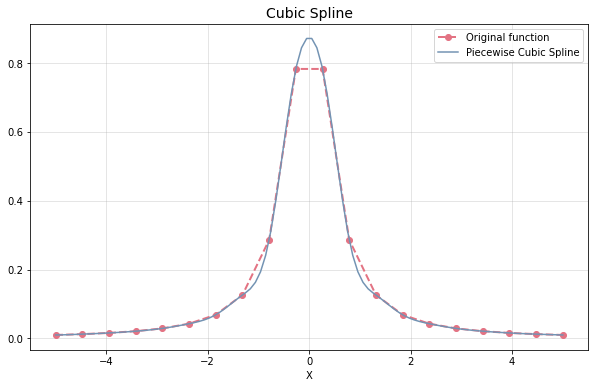

In [11]:
fig = plt.figure(figsize = (10, 6))

ax = fig.add_subplot(1,1,1)
ax.set_title('Cubic Spline', size = 14)
ax.set_xlabel('X')

#Original function
ax.plot(X_base, Y_base, color = '#E37383', label = 'Original function', linestyle = '--', marker = 'o', lw = 2)

#Cubic spline
ax.plot(X, Y, color = '#7393B3' , label = 'Piecewise Cubic Spline')
ax.legend()
ax.grid(alpha = 0.4)

plt.show()